# Machine Learning application: Forecasting wind power. Using alternative energy for social & enviromental Good

<table>
  <tr><td>
    <img src="https://github.com/dmatrix/mlflow-workshop-part-3/raw/master/images/wind_farm.jpg"
         alt="Keras NN Model as Logistic regression"  width="800">
  </td></tr>
</table>

In this notebook, we will use the MLflow Model Registry to build a machine learning application that forecasts the daily power output of a [wind farm](https://en.wikipedia.org/wiki/Wind_farm). 

Wind farm power output depends on weather conditions: generally, more energy is produced at higher wind speeds. Accordingly, the machine learning models used in the notebook predicts power output based on weather forecasts with three features: `wind direction`, `wind speed`, and `air temperature`.

* This notebook uses altered data from the [National WIND Toolkit dataset](https://www.nrel.gov/grid/wind-toolkit.html) provided by NREL, which is publicly available and cited as follows:*

* Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. Overview and Meteorological Validation of the Wind Integration National Dataset Toolkit (Technical Report, NREL/TP-5000-61740). Golden, CO: National Renewable Energy Laboratory.*

* Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. "The Wind Integration National Dataset (WIND) Toolkit." Applied Energy 151: 355366.*

* Lieberman-Cribbin, W., C. Draxl, and A. Clifton. 2014. Guide to Using the WIND Toolkit Validation Code (Technical Report, NREL/TP-5000-62595). Golden, CO: National Renewable Energy Laboratory.*

* King, J., A. Clifton, and B.M. Hodge. 2014. Validation of Power Output for the WIND Toolkit (Technical Report, NREL/TP-5D00-61714). Golden, CO: National Renewable Energy Laboratory.*

Google's DeepMind publised a [AI for Social Good: 7 Inspiring Examples](https://www.springboard.com/blog/ai-for-good/) blog. One of example was
how Wind Farms can predict expected power ouput based on wind conditions and temperature, hence mitigating the burden from consuming
energy from fossil fuels. 


<table>
  <tr><td>
    <img src="https://github.com/dmatrix/ds4g-workshop/raw/master/notebooks/images/deepmind_system-windpower.gif"
         alt="Deep Mind ML Wind Power"  width="400">
    <img src="https://github.com/dmatrix/ds4g-workshop/raw/master/notebooks/images/machine_learning-value_wind_energy.max-1000x1000.png"
         alt="Deep Mind ML Wind Power"  width="400">
  </td></tr>
</table>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import mlflow
mlflow.__version__

'1.17.0'

## Run some class and utility notebooks 

This defines and allows us to use some Python model classes and utility functions

In [3]:
%run ./rfr_class.ipynb

In [4]:
%run ./utils_class.ipynb

## Load our training data

Ideally, you would load it from a Feature Store or Delta Lake table

In [5]:
# Load and print dataset
csv_path = "https://raw.githubusercontent.com/dmatrix/olt-mlflow/master/model_registery/notebooks/data/windfarm_data.csv"

# Use column 0 (date) as the index
wind_farm_data = Utils.load_data(csv_path, index_col=0)
wind_farm_data.head(5)

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2014-01-01,4.702022,106.742590,4.743292,7.189482,100.41638,6.593832,8.172301,99.28800,5.967206,1959.3535
2014-01-02,7.695733,98.036705,6.142715,9.977118,94.03181,4.383676,9.690135,204.25444,1.696528,1266.6239
2014-01-03,9.608235,274.061200,10.514304,10.840864,242.87563,16.869741,8.991079,250.26830,12.038399,7545.6797
2014-01-04,6.955563,257.910220,7.189170,5.317223,254.26170,9.069233,3.021174,284.06537,4.590843,3791.0408
2014-01-05,0.830547,265.394400,4.263086,2.480239,104.79496,3.042063,4.227131,263.41690,3.899182,880.6115


## Get Training and Validation data

In [6]:
X_train, y_train = Utils.get_training_data(wind_farm_data)
val_x, val_y = Utils.get_validation_data(wind_farm_data)

## Initialize a set of hyperparameters for the training and try three runs

In [7]:
# Initialize our model hyperparameters
params_list = [{"n_estimators": 100},
               {"n_estimators": 200},
               {"n_estimators": 300}]

In [8]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")
model_name = "WindfarmPowerForecastingModel"
for params in params_list:
  rfr = RFRModel.new_instance(params)
  print("Using paramerts={}".format(params))
  runID = rfr.mlflow_run(X_train, y_train, val_x, val_y, model_name, register=True)
  print("MLflow run_id={} completed with MSE={} and RMSE={}".format(runID, rfr.mse, rfr.rsme))

Using paramerts={'n_estimators': 100}


2021/06/07 09:46:47 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2021/06/07 09:46:47 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

MLflow run_id=2fb618ac5974449989244af6300baa4d completed with MSE=46861.29380556153 and RMSE=216.4746955317446
Using paramerts={'n_estimators': 200}


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'WindfarmPowerForecastingModel' already exists. Creating a new version of this model...
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.

MLflow run_id=b302c9cb26934d5dba8b79e6da801a72 completed with MSE=43933.41456242744 and RMSE=209.60299273251667
Using paramerts={'n_estimators': 300}


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'WindfarmPowerForecastingModel' already exists. Creating a new version of this model...
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.

MLflow run_id=272d5bcf6bab49a79f107b0a3c3734d1 completed with MSE=44610.351395384845 and RMSE=211.21162703645092


## Let's Examine the MLflow UI
1. Let's examine some models and start comparing their metrics
2. **mlflow ui --backend-store-uri sqlite:///mlruns.db**

# Integrating Model Registry with CI/CD Forecasting Application

<table>
  <tr><td>
    <img src="https://github.com/dmatrix/mlflow-workshop-part-3/raw/master/images/forecast_app.png"
         alt="Keras NN Model as Logistic regression"  width="800">
  </td></tr>
</table>

1. Use the model registry fetch different versions of the model
2. Score the model
3. Select the best scored model
4. Promote model to production, after testing

# Define a helper function to load PyFunc model from the registry
<table>
  <tr><td> Save a Built-in MLflow Model Flavor and load as PyFunc Flavor</td></tr>
  <tr><td>
    <img src="https://raw.githubusercontent.com/dmatrix/mlflow-workshop-part-2/master/images/models_2.png"
         alt="" width="600">
  </td></tr>
</table>

In [9]:
def score_model(data, model_uri):
    model = mlflow.pyfunc.load_model(model_uri)
    return model.predict(data)

## Load scoring data

Again, ideally you would load it from on-line or off-line FeatureStore

In [10]:
# Load the score data
score_path = "https://raw.githubusercontent.com/dmatrix/olt-mlflow/master/model_registery/notebooks/data/score_windfarm_data.csv"
score_df = Utils.load_data(score_path, index_col=0)
score_df.head()

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2020-12-27,7.123225,103.176630,8.133746,6.454002,107.793220,6.326991,7.219884,119.070526,3.062219,2621.4760
2020-12-28,5.376270,118.084330,5.558247,8.118839,116.193535,8.565966,9.307176,120.264430,11.993913,5423.6250
2020-12-29,8.593436,115.432590,12.181850,8.587968,112.931360,11.970859,8.956771,110.161095,11.301485,9132.1150
2020-12-30,8.069033,103.169685,9.983466,7.930485,106.045510,6.381556,8.228901,111.602160,4.087358,3667.9927


In [11]:
# Drop the power column since we are predicting that value
actual_power = pd.DataFrame(score_df.power.values, columns=['power'])
score = score_df.drop("power", axis=1)

## Score the version 1 of the model

In [12]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 1)

# Predict the Power output 
pred_1 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_1"])
pred_1

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_1
0,2838.873198
1,5120.368649
2,8697.734587
3,3758.674182


#### Combine with the actual power

In [13]:
actual_power["predicted_1"] = pred_1["predicted_1"]
actual_power

,power,predicted_1
0,2621.4760,2838.873198
1,5423.6250,5120.368649
2,9132.1150,8697.734587
3,3667.9927,3758.674182


## Score the version 2 of the model

In [14]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 2)

# Predict the Power output
pred_2 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_2"])
pred_2

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_2
0,2800.219030
1,5126.206971
2,8746.306752
3,3858.939059


#### Combine with the actual power

In [15]:
actual_power["predicted_2"] = pred_2["predicted_2"]
actual_power

,power,predicted_1,predicted_2
0,2621.4760,2838.873198,2800.219030
1,5423.6250,5120.368649,5126.206971
2,9132.1150,8697.734587,8746.306752
3,3667.9927,3758.674182,3858.939059


## Score the version 3 of the model

In [16]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 3)

# Formulate the model URI to fetch from the model registery
pred_3 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_3"])
pred_3

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_3
0,2794.897296
1,5114.314851
2,8726.843493
3,3827.788594


#### Combine the values into a single pandas DataFrame

In [17]:
actual_power["predicted_3"] = pred_3["predicted_3"]
actual_power

,power,predicted_1,predicted_2,predicted_3
0,2621.4760,2838.873198,2800.219030,2794.897296
1,5423.6250,5120.368649,5126.206971,5114.314851
2,9132.1150,8697.734587,8746.306752,8726.843493
3,3667.9927,3758.674182,3858.939059,3827.788594


## Plot the combined predicited results vs the actual power

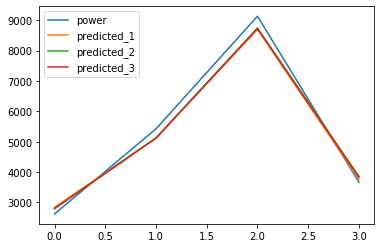

In [18]:
%matplotlib inline

actual_power.plot.line()